# Project:
By:Abhishek Bagaria

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
#setting seed so that will get same results on each runs
np.random.seed(7)

About dataset
This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

Field	Description
Loan_status	Whether a loan is paid off on in collection
Principal	Basic principal loan amount at the
Terms	Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule
Effective_date	When the loan got originated and took effects
Due_date	Since it’s one-time payoff schedule, each loan has one single due date
Age	Age of applicant
Education	Education of applicant
Gender	The gender of applicant

Lets download the dataset

In [3]:
path = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'

Load Data From CSV File

In [4]:
df = pd.read_csv(path)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

As these effective and due date format is absurd so converting these to proper format:

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Now we will Do Data VIsualisation and preprocessing

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [8]:
#notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

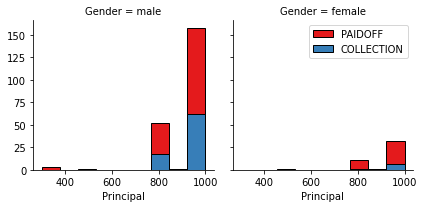

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
h = sns.FacetGrid(df, col='Gender', hue='loan_status', palette='Set1', col_wrap=2)
h.map(plt.hist, 'Principal', bins=bins, ec='k')

h.axes[-1].legend()
plt.show()

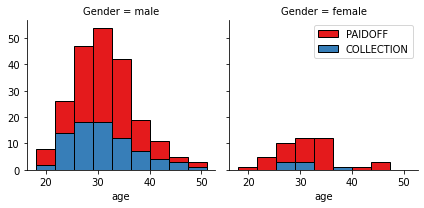

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing: Feature selection/extraction

Lets look at the day of the week people get the loan¶


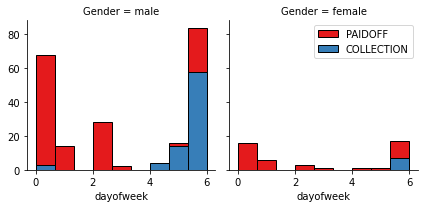

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Lets look at the Months people get the loan¶


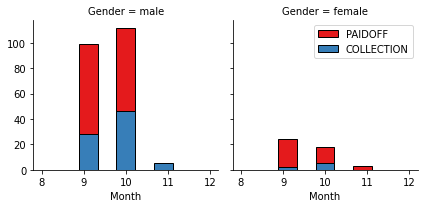

In [12]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min()-1, df.Month.max()+1, 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


there is higher possibility that people pay off the loan in 9th month than paying it in 10th or 11th
as the observation shows people who get the loan at the end of the week don't pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,10,1


# Convert Categorical features to numerical values

Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)


Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Lets convert male to 0 and female to 1:



In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1


In [16]:
df['deadline']= df['due_date'] - df['effective_date']
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29 days
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29 days
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14 days
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29 days
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29 days


In [17]:
df['deadline'] = df['deadline'].dt.days
df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14


based on the tested results columns Month and deadline doesn't improve the result so we will not use them in feature sets of training

# Now One Hot Encoding

Now will have a look at Education

In [18]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [19]:
len(df[df.education=='Master or Above'])

2

In [20]:
len(df[df.education=='Bechalor'])

44

In [21]:
len(df[df.education=='college'])

149

In [22]:
len(df[df.education=='High School or Below'])

151

There are only two people with Master or Above degress,one of them has paid off the loan and the other one hasn't.As a result keeping 'Master or Above' in our data set wont't help much! so we drop it.



We use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame
There are only two people with Master or Above degress,one of them has paid off the loan and the other one hasn't.As a result keeping 'Master or Above' in our data set wont't help much! so we drop it.



In [23]:
Feature = df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


# Feature selection


Our data without label

In [24]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


# Our labels


In [25]:
# We encode our labels as 0 and 1 s
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

# Normalize Data


Data Standardization give data zero mean and unit variance

In [26]:
X= preprocessing.StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.26122054,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679]])

In [27]:
# import scoring methods
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [28]:
# our data for training (used '_train' just for improving readability)
X_train, y_train=X,y

In [29]:
X_train.shape, y_train.shape

((346, 9), (346,))

In [113]:
# a dictionary for keeping all scores of the classifiers
trainscore={}

In [114]:
from sklearn.neighbors import KNeighborsClassifier

bestScore=0.0
accList=[]

for k in range(3,12):
    
    clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
    # using 10 fold cross validation for scoring the classifier's accuracy
    scores = cross_val_score(clf_knn, X, y, cv=10)
    score=scores.mean()
    accList.append(score)
    
    if score > bestScore:
        bestScore=score
        best_clf=clf_knn
        bestK=k
        
print("Best K is :",bestK,"| Cross validation Accuracy :",bestScore)
clf_knn=best_clf

Best K is : 8 | Cross validation Accuracy : 0.7522689075630252


In [115]:
clf_knn.fit(X_train,y_train)
y_pred=best_clf.predict(X_train)

In [116]:
trainscore['KNN-jaccard']=jaccard_score(y_train, y_pred, pos_label=0)
trainscore['KNN-f1-score']=f1_score(y_train, y_pred, average='weighted')

In [117]:
trainscore

{'KNN-jaccard': 0.7753164556962026, 'KNN-f1-score': 0.7701843558681992}

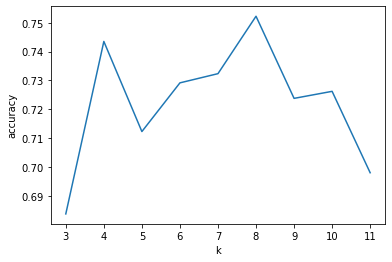

In [118]:
plt.plot(range(3,12), acclist)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

# Decision Tree

In [119]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_train)

In [120]:
trainscore['Tree-jaccard']=jaccard_score(y_train, y_pred, pos_label=0)
trainscore['Tree-f1-score']=f1_score(y_train, y_pred, average='weighted')

In [121]:
trainscore

{'KNN-jaccard': 0.7753164556962026,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.9110320284697508,
 'Tree-f1-score': 0.924927020820985}

### Visualizng the tree

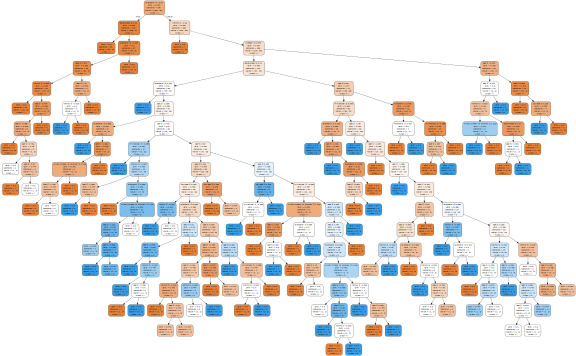

In [125]:
!pip install graphviz
!pip install pydotplus
import graphviz 
import pydotplus

dot_data = tree.export_graphviz(clf_tree, out_file=None,feature_names=['Principal',
                                    'terms','age',
                                    'Gender',
                                    'weekend',
                                    'Bechalor',
                                    'High School or Below',
                                    'college',
                                    'dayofweek',
                                     #'deadline'
#                                     ,'Month'
                                   ],class_names='loan_status',  
                     filled=True, rounded=True,  
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"8,8!"')
gvz_graph = graphviz.Source(graph.to_string())

gvz_graph

## Support Vector Machine

In [127]:
y_train=y_train.astype(float)

In [128]:
from sklearn import svm

clf_svm = svm.LinearSVC(random_state = 7)
clf_svm.fit(X_train, y_train)
y_pred=clf_svm.predict(X_train)

In [129]:
trainscore['SVM-jaccard']=jaccard_score(y_train, y_pred, pos_label=0)
trainscore['SVM-f1-score']=f1_score(y_train, y_pred, average='weighted')

In [130]:
trainscore

{'KNN-jaccard': 0.7753164556962026,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.9110320284697508,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.7478005865102639,
 'SVM-f1-score': 0.6689062277741139}

## Logistic Regression

In [131]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf_log.fit(X_train, y_train)

y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)

In [133]:
trainscore['LogReg-jaccard']=jaccard_score(y_train, y_pred, pos_label=0)
trainscore['LogReg-f1-score']=f1_score(y_train, y_pred, average='weighted')  
trainscore['LogReg-logLoss']=log_loss(y_train, y_proba)

In [134]:
trainscore

{'KNN-jaccard': 0.7753164556962026,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.9110320284697508,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.7478005865102639,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-jaccard': 0.7530120481927711,
 'LogReg-f1-score': 0.7088399037150602,
 'LogReg-logLoss': 0.43174993676801543}

# Model Evaluation using Test set

In [135]:
path1 = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'

In [136]:
test_df = pd.read_csv(path)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [137]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# test_df['Month'] = test_df.due_date.dt.month 

# test_df['deadline']=test_df['due_date']-test_df['effective_date']
# test_df['deadline']=test_df['deadline'].dt.days

Feature = test_df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X = Feature

y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values

testy=y.astype(float)
testX= preprocessing.StandardScaler().fit_transform(X)

In [138]:
testScores={}


In [140]:
knn_pred=clf_knn.predict(testX)
testScores['KNN-jaccard']=jaccard_score(testy, knn_pred, pos_label=0)
testScores['KNN-f1-score']=f1_score(testy, knn_pred, average='weighted')

In [141]:
tree_pred=clf_tree.predict(testX)
testScores['Tree-jaccard']=jaccard_score(testy, tree_pred,pos_label=0)
testScores['Tree-f1-score']=f1_score(testy, tree_pred, average='weighted')

In [143]:
svm_pred=clf_svm.predict(testX)
testScores['SVM-jaccard']=jaccard_score(testy, svm_pred, pos_label=0)
testScores['SVM-f1-score']=f1_score(testy, svm_pred, average='weighted')

In [144]:
log_pred=clf_log.predict(testX)
proba=clf_log.predict_proba(testX)
testScores['LogReg-jaccard']=jaccard_score(testy, log_pred, pos_label=0)
testScores['LogReg-f1-score']=f1_score(testy, log_pred, average='weighted')  
testScores['LogReg-logLoss']=log_loss(testy, proba)

In [147]:
trainscore

{'KNN-jaccard': 0.7753164556962026,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.9110320284697508,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.7478005865102639,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-jaccard': 0.7530120481927711,
 'LogReg-f1-score': 0.7088399037150602,
 'LogReg-logLoss': 0.43174993676801543}

In [148]:
testScores

{'KNN-jaccard': 0.7753164556962026,
 'KNN-f1-score': 0.7701843558681992,
 'Tree-jaccard': 0.9110320284697508,
 'Tree-f1-score': 0.924927020820985,
 'SVM-jaccard': 0.7478005865102639,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-jaccard': 0.7530120481927711,
 'LogReg-f1-score': 0.7088399037150602,
 'LogReg-logLoss': 0.43174993676801543}

In [149]:
# Features used
list(Feature.columns)

['Principal',
 'terms',
 'age',
 'Gender',
 'weekend',
 'dayofweek',
 'Bechalor',
 'High School or Below',
 'college']

# Reports:

Algorithm	Jaccard 	F1-score	LogLoss score respectively

KNN	         0.7407	     0.7144	    NA

Decision Tree 0.7592	0.7618	    NA

SVM	         0.7592	    0.6959      NA

LogisticRegression	0.7777	0.7089	0.4947

In [ ]:
Even though Decision tree had shown a relatively good result in trainig ,but it is Logistic Regression that out-performs the other models in test .
out tree model suffers from over-fitting